## Low-discrepancy pointset randomizations including higher order digital nets

## Setup

In [1]:
import qmcpy as qp
import numpy as np
import timeit
from matplotlib import pyplot
from collections import OrderedDict
import os

In [2]:
pyplot.style.use("seaborn-v0_8-pastel")
colors = [
    "xkcd:purple",
    "xkcd:green",
    "xkcd:blue",
    "xkcd:pink",
    "xkcd:brown",
    "xkcd:red",
    "xkcd:orange",
    "xkcd:violet",
    "xkcd:grey",
]

## Snippets

In [3]:
%%time 
lattice = qp.Lattice(
    dimension = 52,
    randomize = "shift", # for unrandomized lattice set randomize = False
    replications = 16, # R
    order = "natural", # also supports "linear" and "Gray" for Gray code
    seed = None, # pass integer seed for reproducibility
    generating_vector = "LDData:mps.exod2_base2_m20_CKN.txt")
x = lattice(2**16) # a numpy.ndarray with shape 16 x 65536 x 52

CPU times: user 929 ms, sys: 106 ms, total: 1.04 s
Wall time: 1.04 s


In [4]:
%%time
dnb2 = qp.DigitalNetB2(
    dimension = 52, 
    randomize = "LMS_DS", # Matousek's LMS with a digital shift
    # randomize options are [LMS_DS, NUS, DS, LMS, False]
    t_lms = 64, # number of LMS bits i.e. number of rows in S_j
    alpha = 2, # interlacing factor for higher order digital nets
    replications = 16, # R
    graycode = False, # use natural order instead of Gray code order 
    seed = None, # pass integer seed for reproducibility
    generating_matrices = "LDData:mps.sobol_Cs.txt")
x = dnb2(2**16) # a numpy.ndarray with shape 16 x 65536 x 52

CPU times: user 1.11 s, sys: 403 ms, total: 1.51 s
Wall time: 1.52 s


In [5]:
%%time 
halton = qp.Halton(
    dimension = 52, 
    randomize = "LMS_PERM", # Matousek's LMS with a digital permutation
    # randomize options are [LMS_PERM, LMS_DS, LMS, PERM, DS, NUS, QRNG, FALSE]
    t_lms = 64, # number of LMS bits i.e. number of rows in S_j
    replications = 16, # R
    seed = None) # pass integer seed for reproducibility
x = halton(2**10) # a numpy.ndarray with shape 16 x 1024 x 52

CPU times: user 1.39 s, sys: 338 ms, total: 1.73 s
Wall time: 1.73 s


## Pointsets

In [4]:
m = 13 # n = 2^m
n = 2**m # number of points
d = 2 # dimensions

In [4]:
pointsets = OrderedDict({
    "IID": qp.IIDStdUniform(d).gen_samples(n),
    "Lattice + Shift": qp.Lattice(d).gen_samples(n),
    r"DN${}_{2}$ + LMS + DS": qp.DigitalNetB2(d,randomize="LMS_DS").gen_samples(n),
    r"DN${}_{2}$ + NUS": qp.DigitalNetB2(d,randomize="NUS").gen_samples(n),
    "Halton + LMS + DP": qp.Halton(d,randomize="LMS_PERM").gen_samples(n),
    "Halton + NUS": qp.Halton(d,randomize="NUS").gen_samples(n),
    r"HO${}_2$ DN${}_{2}$ + LMS + DS": qp.DigitalNetB2(d,randomize="LMS_DS",alpha=2).gen_samples(n),
    r"HO${}_2$ DN${}_{2}$ + NUS": qp.DigitalNetB2(d,randomize="NUS",alpha=2).gen_samples(n),
    r"HO${}_3$ DN${}_{2}$ + LMS + DS": qp.DigitalNetB2(d,randomize="LMS_DS",alpha=3).gen_samples(n),
    r"HO${}_3$ DN${}_{2}$ + NUS": qp.DigitalNetB2(d,randomize="NUS",alpha=3).gen_samples(n),
    r"HO${}_4$ DN${}_{2}$ + LMS + DS": qp.DigitalNetB2(d,randomize="LMS_DS",alpha=4).gen_samples(n),
    r"HO${}_4$ DN${}_{2}$ + NUS": qp.DigitalNetB2(d,randomize="NUS",alpha=4).gen_samples(n)})

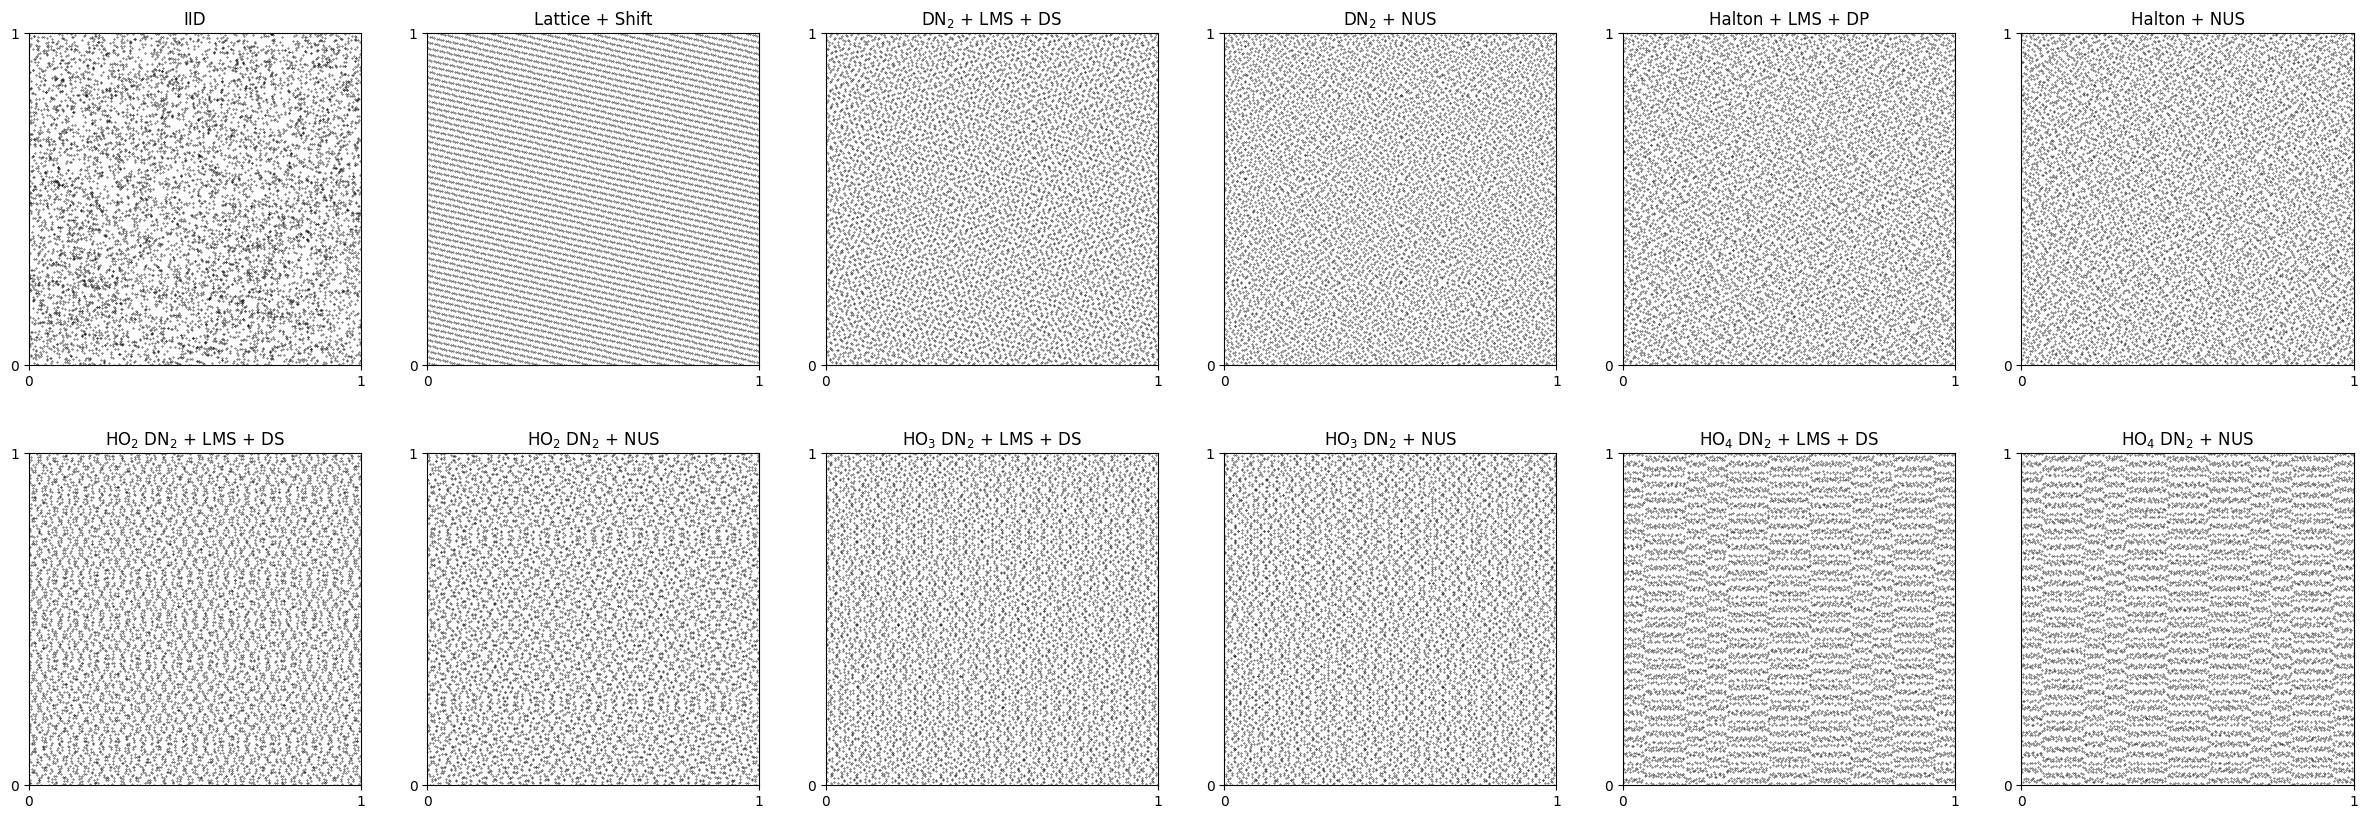

In [7]:
nrows,ncols = 2,6
assert len(pointsets)==(nrows*ncols)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*5,nrows*5))
color = "black"
s = .1
for i,(name,x) in enumerate(pointsets.items()):
    ri,ci = i//ncols,i%ncols
    ax[ri,ci].set_title(name)
    ax[ri,ci].scatter(x[:,0],x[:,1],color=color,s=s)
    ax[ri,ci].set_xlim([0,1]); ax[ri,ci].set_xticks([0,1])
    ax[ri,ci].set_ylim([0,1]); ax[ri,ci].set_yticks([0,1])
    ax[ri,ci].set_aspect(1)
fig.savefig("./pointsets.png",dpi=512,bbox_inches="tight")#,format="png")

## Timing

In [8]:
r = 1
d = 1
reps = 7
m_max = 20

In [9]:
def time_block(pointsets_fns,names):
    p = len(pointsets_fns)
    t = np.nan*np.empty((p,m_max+1),dtype=np.float64)
    times = np.empty(reps,dtype=np.float64)
    for i in range(p):
        print("%25s: "%names[i],end="",flush=True)
        generator = pointsets_fns[i]
        for m in range(0,m_max+1):
            print("%d, "%m,end='',flush=True)
            for r in range(reps):
                t0 = timeit.default_timer()
                x = generator(2**m)
                times[r] = timeit.default_timer()-t0
            t[i,m] = np.median(times)
            if t[i,m]>=1: break
        print()
    return t 

In [15]:
pointsets_noho_fns = [
    lambda n: qp.IIDStdUniform(d,replications=r).gen_samples(n),
    lambda n: qp.Lattice(d,replications=r).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="NUS",replications=r).gen_samples(n),
    lambda n: qp.Halton(d,randomize="LMS_DS",replications=r).gen_samples(n),
    lambda n: qp.Halton(d,randomize="NUS",replications=r).gen_samples(n),]
names_noho = [
    "IID",
    "Lattice + Shift",
    r"DN${}_{2}$ + LMS + DS",
    r"DN${}_{2}$ + NUS",
    "Halton + LMS + DP",
    "Halton + NUS",]
t_noho = time_block(pointsets_noho_fns,names_noho)

                      IID: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
          Lattice + Shift: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
    DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
         DN${}_{2}$ + NUS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
        Halton + LMS + DP: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
             Halton + NUS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 


In [16]:
pointsets_dnb2_lms_ds_ho_fns = [
    lambda n: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=2).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=3).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=4).gen_samples(n),]
names_dnb2_lms_ds_ho_fns = [
    r"$\alpha = %d$"%2,
    r"$\alpha = %d$"%3,
    r"$\alpha = %d$"%4,]
t_dnb2_lms_ds_ho = time_block(pointsets_dnb2_lms_ds_ho_fns,names_dnb2_lms_ds_ho_fns)

             $\alpha = 2$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
             $\alpha = 3$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
             $\alpha = 4$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


In [17]:
pointsets_dnb2_nus_ho_fns = [
    lambda n: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=2).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=3).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=4).gen_samples(n),]
names_dnb2_nus_ho = [
    r"$\alpha = %d$"%2,
    r"$\alpha = %d$"%3,
    r"$\alpha = %d$"%4,]
t_dnb2_nus_ho = time_block(pointsets_dnb2_nus_ho_fns,names_dnb2_nus_ho)

             $\alpha = 2$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
             $\alpha = 3$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
             $\alpha = 4$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 


In [18]:
x_fft  = np.random.rand(2**(m_max+1))+1j*np.random.rand(2**(m_max+1))
x_fwht = np.random.rand(2**(m_max+1))
ft_fns = [
    lambda n: qp.fft_bro_1d_radix2_py(x_fft[:n]),
    lambda n: qp.ifft_bro_1d_radix2_py(x_fft[:n]),
    lambda n: qp.fwht_1d_radix2_py(x_fwht[:n]),]
names_ft = [
    "FFT BRO",
    "IFFT BRO",
    "FWHT",]
t_ft = time_block(ft_fns,names_ft)

                  FFT BRO: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                 IFFT BRO: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                     FWHT: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


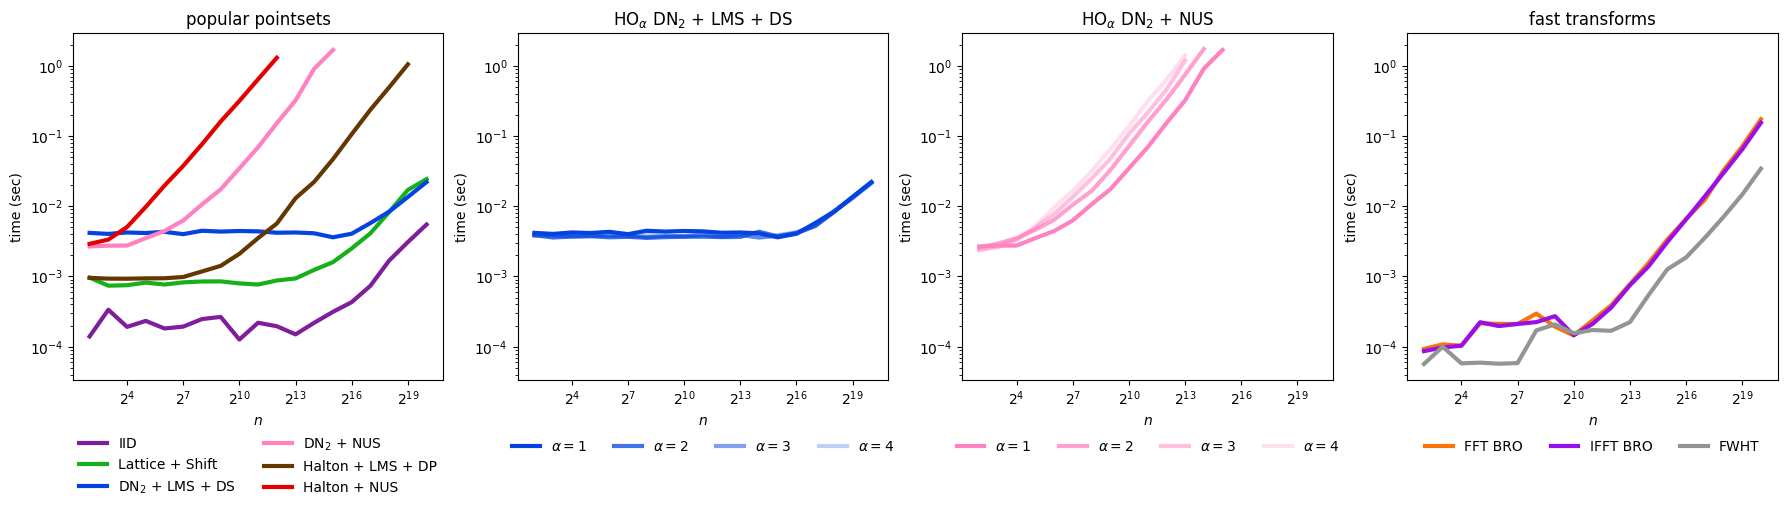

In [22]:
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(4*5.5,1*4.5),sharey=True,sharex=True)
mvec = np.arange(2,m_max+1)
nvec = 2**mvec
linewidth = 3
ax[0].plot(nvec,t_noho[0,mvec],label=names_noho[0],linewidth=linewidth,color=colors[0])
ax[0].plot(nvec,t_noho[1,mvec],label=names_noho[1],linewidth=linewidth,color=colors[1])
ax[0].plot(nvec,t_noho[2,mvec],label=names_noho[2],linewidth=linewidth,color=colors[2])
ax[0].plot(nvec,t_noho[3,mvec],label=names_noho[3],linewidth=linewidth,color=colors[3])
ax[0].plot(nvec,t_noho[4,mvec],label=names_noho[4],linewidth=linewidth,color=colors[4])
ax[0].plot(nvec,t_noho[5,mvec],label=names_noho[5],linewidth=linewidth,color=colors[5])
ax[1].plot(nvec,t_noho[2,mvec],label=r"$\alpha = 1$",linewidth=linewidth,color=colors[2])
ax[1].plot(nvec,t_dnb2_lms_ds_ho[0,mvec],label=names_dnb2_lms_ds_ho_fns[0],linewidth=linewidth,color=colors[2],alpha=.75)#linestyle=(0, (5, 1)))
ax[1].plot(nvec,t_dnb2_lms_ds_ho[1,mvec],label=names_dnb2_lms_ds_ho_fns[1],linewidth=linewidth,color=colors[2],alpha=.50)#linestyle=(0, (5, 5)))
ax[1].plot(nvec,t_dnb2_lms_ds_ho[2,mvec],label=names_dnb2_lms_ds_ho_fns[2],linewidth=linewidth,color=colors[2],alpha=.25)#linestyle=(0, (5, 10)))
ax[2].plot(nvec,t_noho[3,mvec],label=r"$\alpha = 1$",linewidth=linewidth,color=colors[3])
ax[2].plot(nvec,t_dnb2_nus_ho[0,mvec],label=names_dnb2_nus_ho[0],linewidth=linewidth,color=colors[3],alpha=.75)#linestyle=(0, (5, 1)))
ax[2].plot(nvec,t_dnb2_nus_ho[1,mvec],label=names_dnb2_nus_ho[1],linewidth=linewidth,color=colors[3],alpha=.50)#linestyle=(0, (5, 5)))
ax[2].plot(nvec,t_dnb2_nus_ho[2,mvec],label=names_dnb2_nus_ho[2],linewidth=linewidth,color=colors[3],alpha=.25)#linestyle=(0, (5, 10)))
ax[3].plot(nvec,t_ft[0,mvec],label=names_ft[0],linewidth=linewidth,color=colors[6])
ax[3].plot(nvec,t_ft[1,mvec],label=names_ft[1],linewidth=linewidth,color=colors[7])
ax[3].plot(nvec,t_ft[2,mvec],label=names_ft[2],linewidth=linewidth,color=colors[8])
ax[0].set_title("popular pointsets")
ax[1].set_title(r"HO${}_{\alpha}$ DN${}_{2}$ + LMS + DS")
ax[2].set_title(r"HO${}_{\alpha}$ DN${}_{2}$ + NUS")
ax[3].set_title("fast transforms")
ax[0].legend(loc="lower center",frameon=False,bbox_to_anchor=(.5,-.37),ncol=2)
ax[1].legend(loc="lower center",frameon=False,bbox_to_anchor=(.5,-.25),ncol=4)
ax[2].legend(loc="lower center",frameon=False,bbox_to_anchor=(.5,-.25),ncol=4)
ax[3].legend(loc="lower center",frameon=False,bbox_to_anchor=(.5,-.25),ncol=3)
ax[0].set_xscale('log',base=2)
for i in range(4):
    ax[i].set_xlabel(r'$n$')
    ax[i].set_ylabel('time (sec)')
#ax[0].set_xlim([nvec.min(),nvec.max()])
#ax[0].set_xticks(nvec)
ax[0].set_yscale('log',base=10)
for i in range(4):
    ax[i].yaxis.set_tick_params(labelleft=True)
fig.savefig("./timing.png",dpi=512,bbox_inches="tight")#,format="png")

## Convergence

In [111]:
r = 100
m_max = 12
seed = 11

In [103]:
def convergence_block(integrand, pointsets_fns, names):
    d = integrand.true_measure.discrete_distrib.d
    p = len(pointsets_fns)
    t = np.nan*np.empty((p,m_max+1),dtype=np.float64)
    muhat = np.nan*np.empty((p,m_max+1),dtype=np.float64) 
    rmse = np.nan*np.empty((p,m_max+1),dtype=np.float64)
    for i in range(p):
        print("%25s: "%names[i],end="",flush=True)
        generator = pointsets_fns[i]
        for m in range(0,m_max+1):
            print("%d, "%m,end='',flush=True)
            t0 = timeit.default_timer()
            x = generator(2**m,d)
            t[i,m] = timeit.default_timer()-t0
            y = np.stack([integrand.f(x[i]) for i in range(r)])[:,:,0]
            muhats = y.mean(1)
            muhat[i,m] = muhats.mean()
            mse = np.mean((muhats-muhat[i,m])**2/(r*(r-1)))
            rmse[i,m] = np.sqrt(mse)
            if t[i,m]>=1: break
        print()
    return t,muhat,rmse

In [112]:
funcs = [
    qp.CustomFun(
        qp.Uniform(qp.IIDStdUniform(1)),
        lambda x: x[:,0]*np.exp(x[:,0])-1.),
    qp.CustomFun(
        qp.Uniform(qp.IIDStdUniform(2)),
        lambda x: x[:,1]*np.exp(x[:,0]*x[:,1])/(np.exp(1)-2)-1),
    qp.Keister(qp.IIDStdUniform(2)),
    qp.AsianOption(qp.IIDStdUniform(2)),
]
nfuncs = len(funcs)

In [113]:
pointsets_noho_fns = [
    lambda n,d: qp.IIDStdUniform(d,replications=r,seed=seed).gen_samples(n),
    lambda n,d: qp.Lattice(d,replications=r,seed=seed).gen_samples(n),
    lambda n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed).gen_samples(n),
    lambda n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed,alpha=2).gen_samples(n),
    lambda n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed,alpha=3).gen_samples(n),
    lambda n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed,alpha=4).gen_samples(n),
    lambda n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed,alpha=5).gen_samples(n),]
names_noho = [
    "IID",
    "Lattice + Shift",
    r"DN${}_{2}$ + LMS + DS",
    r"$\alpha = %d$"%2,
    r"$\alpha = %d$"%3,
    r"$\alpha = %d$"%4,
    r"$\alpha = %d$"%5,]
data_noho = [convergence_block(func,pointsets_noho_fns,names_noho) for func in funcs]

                      IID: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
          Lattice + Shift: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
    DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
             $\alpha = 2$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
             $\alpha = 3$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
             $\alpha = 4$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
             $\alpha = 5$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
                      IID: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
          Lattice + Shift: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
    DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
             $\alpha = 2$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
             $\alpha = 3$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
             $\alpha = 4$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
             $\alpha = 5$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
                    

In [106]:
# pointsets_dnb2_nus_ho_fns = [
#     lambda n,d: problems.get_dnb2_nus_ho(r,n,d,3,seed=seed),
#     lambda n,d: problems.get_dnb2_nus_ho(r,n,d,5,seed=seed),
#     lambda n,d: problems.get_dnb2_nus_ho(r,n,d,7,seed=seed),
# ]
# names_dnb2_nus_ho = [
#     r"$\alpha = %d$"%3,
#     r"$\alpha = %d$"%5,
#     r"$\alpha = %d$"%7,
# ]

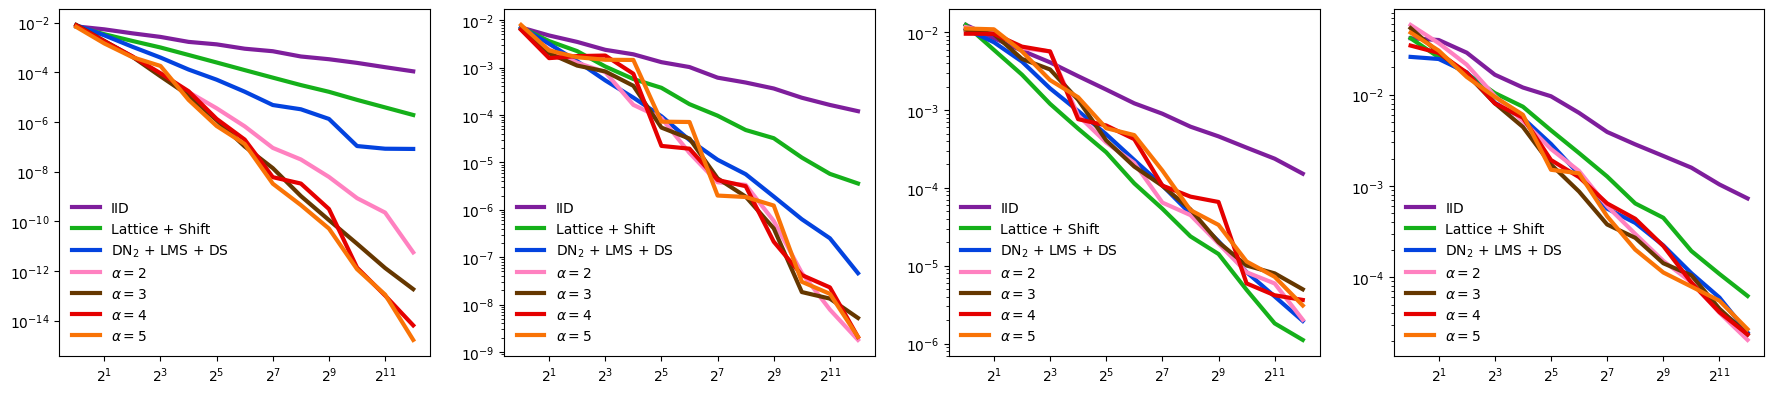

In [115]:
fig,ax = pyplot.subplots(nrows=1,ncols=nfuncs,figsize=(nfuncs*5.5,1*4.5),sharey=False,sharex=True)
ax = np.atleast_1d(ax)
mvec = np.arange(0,m_max+1)
nvec = 2**mvec
linewidth = 3
for i in range(nfuncs):
    t_noho,muhat_noho,rmse_noho = data_noho[i]
    for j in range(len(t_noho)):
        ax[i].plot(nvec,rmse_noho[j,mvec],label=names_noho[j],linewidth=linewidth,color=colors[j])

    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[0,mvec],label=names_dnb2_lms_ds_ho_fns[0],linewidth=linewidth,color=colors[0])
    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[1,mvec],label=names_dnb2_lms_ds_ho_fns[1],linewidth=linewidth,color=colors[1])
    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[2,mvec],label=names_dnb2_lms_ds_ho_fns[2],linewidth=linewidth,color=colors[2])
    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[3,mvec],label=names_dnb2_lms_ds_ho_fns[3],linewidth=linewidth,color=colors[3])
    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[4,mvec],label=names_dnb2_lms_ds_ho_fns[4],linewidth=linewidth,color=colors[4])

    # t_dnb2_nus_ho,muhat_dnb2_nus_ho,rmse_dnb2_nus_ho = convergence_block(d,func,pointsets_dnb2_nus_ho_fns,names_dnb2_nus_ho)
    # ax[i,2].plot(nvec,rmse_dnb2_nus_ho[0,mvec],label=names_dnb2_nus_ho[0],linewidth=linewidth,color=colors[0])
    # ax[i,2].plot(nvec,rmse_dnb2_nus_ho[1,mvec],label=names_dnb2_nus_ho[1],linewidth=linewidth,color=colors[1])
    # ax[i,2].plot(nvec,rmse_dnb2_nus_ho[2,mvec],label=names_dnb2_nus_ho[2],linewidth=linewidth,color=colors[2])

    ax[i].legend(frameon=False)

    ax[i].set_yscale('log',base=10)
ax[0].set_xscale('log',base=2)
fig.savefig("./convergence.png",dpi=128,bbox_inches="tight")#,format="png")